In [1]:
#!pip install yfinance --upgrade --no-cache-dir

In [2]:
#!pip freeze | grep yfinance

In [1]:
from datetime import datetime, timedelta
import sys

import pandas as pd
#from twelvedata import TDClient
#import yfinance as yf

sys.path.append('..')
import yf_clone.yfinance as yfc

sent: <object object at 0x12f8a4850>


In [2]:
#with open('./.env', 'r') as f:
#    for line in f:
#        if line.startswith('TWELVE_DATA_API_KEY'):
#            api_key = line.split('=')[-1].strip()
#            
#td_client = TDClient(apikey=api_key)

In [3]:
DATA = '../data'
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
STATE_RANGE = range(3, 11)
START = '1965-01-01'
TOMORROW

datetime.date(2025, 5, 17)

In [4]:
def td2yf(df):
    'Convert twelvedata format to yfinance format'
    df.drop(columns=['volume'], inplace=True)
    df['Value'] = df.close.copy()
    symbols = sorted(list({i[0] for i in df.index}))
    dfs = [df.loc[sym] for sym in symbols]
    for sym, df in zip(symbols, dfs):
        df.columns = pd.MultiIndex.from_tuples(
            [(col, sym) for col in ['Open', 'High', 'Low', 'Close', 'Value']])
    return pd.concat(dfs, axis=1).astype(np.float64)

In [5]:
def download_td(symbols, start, end):
    df = td_client.time_series(
        symbol=symbols,
        interval='1day',
        start_date=start,
        end_date=end,
        outputsize=5000,
        timezone='Exchange',
        order='asc'
    ).as_pandas()
    df = td2yf(df)
    return df

In [6]:
#sp = download_td('^GSPC', start=START, end=str(TOMORROW))
#print(sp.shape)
#sp.head()

In [7]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']
sp = yfc.download(
    '^GSPC', start=START, end=str(TOMORROW)).sort_index()
#).sort_index()
sp.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1965-01-04,84.230003,85.150002,83.769997,0.0,3930000
1965-01-05,84.629997,85.019997,84.019997,0.0,4110000
1965-01-06,84.889999,85.379997,84.449997,0.0,4850000
1965-01-07,85.260002,85.620003,84.660004,0.0,5080000
1965-01-08,85.370003,85.839996,84.910004,0.0,5340000


In [8]:
sp.columns = cols
sp['Adj Close'] = sp.Close

path = '../data'
sp.to_csv(f'{path}/sp1950.csv')

In [9]:

#nyse = yf.download(
#    '^NYA', start=START, end=str(TOMORROW)).sort_index()
#nyse.columns = cols
#nyse['Adj Close'] = nyse.Close

nas = yfc.download(
    '^IXIC', start=START, end=str(TOMORROW)).sort_index()
nas.columns = cols
nas['Adj Close'] = nas.Close

#wil = yf.download(
#    '^W5000', start='1990-01-01', end=str(TOMORROW))

#nyse.to_csv(f'{path}/nya1965.csv')
nas.to_csv(f'{path}/nasdaq1965.csv')
#wil.to_csv(f'{path}/wilshire1990.csv')

#sp = pd.read_csv(f'{DATA}/sp1950.csv')
#nyse = pd.read_csv(f'{DATA}/nya1965.csv')
#nas = pd.read_csv(f'{DATA}/nasdaq1965.csv')

#wil = pd.read_csv(f'{DATA}/wilshire1990.csv')

[*********************100%***********************]  1 of 1 completed


In [10]:
sp.tail()

,Close,High,Low,Open,Volume,Adj Close
Date,,,,,,
2025-05-12,5844.189941,5845.370117,5786.080078,5807.200195,6014580000,5844.189941
2025-05-13,5886.549805,5906.640137,5845.020020,5854.149902,5516290000,5886.549805
2025-05-14,5892.580078,5906.549805,5872.109863,5896.740234,5233450000,5892.580078
2025-05-15,5916.930176,5924.209961,5865.160156,5869.819824,4991290000,5916.930176
2025-05-16,5958.379883,5958.620117,5907.359863,5929.089844,2919453000,5958.379883


In [11]:
nas.tail()

,Close,High,Low,Open,Volume,Adj Close
Date,,,,,,
2025-05-05,17844.240234,17965.640625,17792.080078,17817.009766,7075320000,17844.240234
2025-05-06,17689.660156,17830.349609,17592.880859,17623.210938,6958220000,17689.660156
2025-05-07,17738.160156,17820.289062,17503.009766,17706.830078,7977870000,17738.160156
2025-05-08,17928.140625,18096.000000,17776.000000,17920.150391,8500390000,17928.140625
2025-05-09,17928.916016,18068.898438,17853.835938,18022.500000,7996718000,17928.916016


In [6]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [38]:
import json

with open('/Users/damiansp/Desktop/indices.json', 'r') as f:
    stocks = json.load(f)

In [42]:
stocks['data']

[{'symbol': '00000020',
  'name': 'BOLSA BILBAO INDEX',
  'country': 'Spain',
  'currency': 'EUR',
  'exchange': 'BME',
  'mic_code': 'XBIL'},
 {'symbol': '000001',
  'name': 'SSE Composite Index',
  'country': 'China',
  'currency': 'CNY',
  'exchange': 'SSE',
  'mic_code': 'XSHG'},
 {'symbol': '000002',
  'name': 'SSE A Share Index',
  'country': 'China',
  'currency': 'CNY',
  'exchange': 'SSE',
  'mic_code': 'XSHG'},
 {'symbol': '000003',
  'name': 'SSE B Share Index',
  'country': 'China',
  'currency': 'USD',
  'exchange': 'SSE',
  'mic_code': 'XSHG'},
 {'symbol': '000004',
  'name': 'SSE Industrial Index',
  'country': 'China',
  'currency': 'CNY',
  'exchange': 'SSE',
  'mic_code': 'XSHG'},
 {'symbol': '000005',
  'name': 'SSE Commercial Index',
  'country': 'China',
  'currency': 'CNY',
  'exchange': 'SSE',
  'mic_code': 'XSHG'},
 {'symbol': '000006',
  'name': 'SSE Real Estate Index',
  'country': 'China',
  'currency': 'CNY',
  'exchange': 'SSE',
  'mic_code': 'XSHG'},
 {'sy

In [43]:
[d for d in stocks['data'] if d['country'] == 'United States'
]#and 'S&P' in d['name']                
 #and d['exchange'] in ['NSE', 'NASDAQ', 'OTC']]

[]

In [34]:
# if yahoo finance not working us twelvedata instead
import os

from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
from twelvedata import TDClient
from twelvedata.exceptions import BadRequestError

load_dotenv()

True

In [11]:
API_KEY = os.getenv('TWELVE_DATA_API_KEY')

In [12]:
client = TDClient(apikey=API_KEY)

In [37]:
dfs = []
start = START
end = str(TOMORROW)

df = client.time_series(
    symbol='GSPC',  # IVV: S&P, NASDAQ
    interval='1day',
    start_date=START,
    end_date=str(TOMORROW),
    outputsize=5000,
    timezone='Exchange',
    order='asc'
).as_pandas()
dfs.append(df)

TwelveDataError: **symbol** or **figi** parameter is missing or invalid. Please provide a valid symbol according to API documentation: https://twelvedata.com/docs#reference-data

In [25]:
end = str(dfs[-1].index[0]).split()[0]
start = datetime.fromisoformat(end) - timedelta(20 * 365)

while str(start) > START:
    print(str(start), end)
    try:
        df = client.time_series(
            symbol='IVV',  # Vanguard 500, Nasdaq Composite
            interval='1day',
            start_date=start,
            end_date=end,
            outputsize=5000,
            timezone='Exchange',
            order='asc'
        ).as_pandas()
        dfs.append(df)
    except BadRequestError:
        break
    end = str(dfs[-1].index[0]).split()[0]
    start = datetime.fromisoformat(end) - timedelta(20 * 365)

1985-04-16 00:00:00 2005-04-11
1980-05-24 00:00:00 2000-05-19


In [30]:
df = pd.concat(dfs)
df.sort_index(inplace=True)

In [31]:
df.head()

,open,high,low,close,volume
datetime,,,,,
2000-05-19,142.65625,142.65625,140.25000,140.68750,775500
2000-05-22,140.59375,140.59375,136.81250,139.81250,1850600
2000-05-23,140.21875,140.21875,137.68750,137.68750,373900
2000-05-24,137.75000,140.06250,136.65625,139.75000,400300
2000-05-25,140.03125,140.93750,137.87500,138.46875,69600


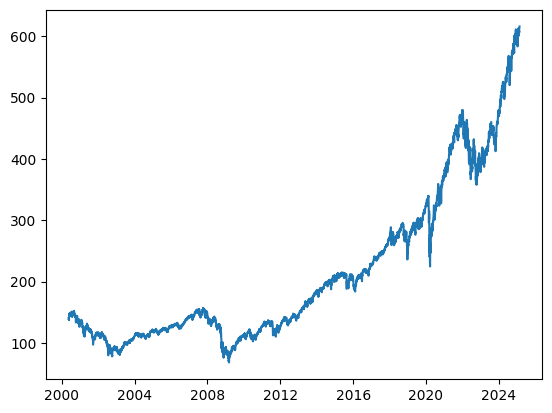

In [35]:
plt.plot(df.index, df.close);

In [45]:
end = str(df.index[0]).split()[0]
start = datetime.fromisoformat(end) - timedelta(20 * 365)
start, end

(datetime.datetime(1985, 4, 16, 0, 0), '2005-04-11')

In [1]:
data = (
    yf
    .download({'AATK', 'ABCO', 'ABAC', 'ABCW', 'AANB', 'AACC', 'ABBC'}, start='2020-01-01', end=TOMORROW)
    .rename(columns={'Adj Close': 'AdjClose'}))#['AdjClose']
data

NameError: name 'yf' is not defined

In [2]:
x = sp['Adj Close'].to_numpy()
np.append([np.nan], x[1:] / x[:-1])

NameError: name 'sp' is not defined

In [3]:
def get_daily_changes(series):
    x = series.to_numpy()
    return np.append([1], x[1:] / x[:-1])

In [ ]:
def prep_df(df, name):
    df.index = pd.to_datetime(df.index)
    df[f'{name}_daily'] = get_daily_changes(df['Adj Close'])
    df.rename(columns={'Adj Close': name}, inplace=True)
    return df[[name, f'{name}_daily']]

In [ ]:
[sp, nyse, nas, wil] = [
    prep_df(df, name) 
    for df, name in zip(
        [sp, nyse, nas, wil], ['sp', 'nyse', 'nas', 'wil'])]
sp.head()

In [ ]:
nyse.head()

In [ ]:
nas.head()

In [ ]:
def find_best_mod(
        daily,
        n_states=[6, 7, 8],
        max_iter=1000,
        reps=3,
        best_logprob=None,
        best_mod=None,
        best_states=None):
    daily = np.reshape(daily.values, [-1, 1])
    best_logprob = best_logprob or -np.inf
    best_mod = best_mod or None
    best_states = best_states or None
    for states in n_states:
        for rep in range(reps):
            try:
                print(f'rep {rep + 1}', end='\r')
                for cov in ['spherical', 'diag', 'full']:
                    mod = GaussianHMM(
                        n_components=states,
                        covariance_type=cov,
                        n_iter=max_iter
                    ).fit(daily)
                    logprob = mod.score(daily)
                    if logprob > best_logprob:
                        print(f'New best - States: {states} (cov: {cov})')
                        best_logprob = logprob
                        best_mod = mod
                        best_states = states
            except ValueError:
                pass
    return best_mod, best_logprob, best_states

In [ ]:
def get_preds(daily, mod):
    daily = np.reshape(daily.values, [-1, 1])
    states = mod.predict(daily)
    means = np.squeeze(mod.means_)
    sds = np.squeeze(np.sqrt(mod.covars_))
    preds = np.array([means[state] for state in states])
    ses = np.array([1.96 * sds[state] for state in states])
    return preds, ses, means, states[-1]

In [ ]:
def plot_mod(df, preds, ses, name):
    daily = f'{name}_daily'
    plt.plot(df[daily], label='daily')
    plt.plot(df.index, preds, label='preds')
    plt.legend()

    plt.figure()
    plt.plot(df[daily], label='daily')
    plt.plot(
        df.index, preds, label='preds', color='orange', linewidth=3)
    plt.plot(df.index, preds + ses, color='orange', linestyle='-.')
    plt.plot(df.index, preds - ses, color='orange', linestyle='-.')
    plt.axhline(y=1, color='k')
    plt.ylim([0.95, 1.05]);
    plt.xlim([df.index[-500], df.index[-1]])

    plt.figure()
    plt.plot(df[name])
    plt.xlim([df.index[-500], df.index[-1]])
    sub = df.iloc[-500:, :]
    plt.ylim(
        0.95 * sub[name].min(), 1.05 * sub[name].max());

In [ ]:
def get_expected_val(mod, current_state, means):
    return np.dot(mod.transmat_[current_state, :], means)

In [ ]:
# start search from previous day's best
with open(f'{DATA}/hmm_mods.pkl', 'rb') as f:
    out_data  = pickle.load(f)

out_data

In [ ]:
sp_prob, sp_mod, sp_best_states = (
    out_data['^GSPC']['logprob'], out_data['^GSPC']['mod'], out_data['^GSPC']['n_states'])
nyse_prob, nyse_mod, nyse_best_states = (
    out_data['^NYA']['logprob'], out_data['^NYA']['mod'], out_data['^NYA']['n_states'])
nas_prob, nas_mod, nas_best_states = (
    out_data['^IXIC']['logprob'], out_data['^IXIC']['mod'], out_data['^IXIC']['n_states'])
wil_prob, wil_mod, wil_best_states = (
    out_data['^W5000']['logprob'], out_data['^W5000']['mod'], out_data['^W5000']['n_states'])

In [ ]:
type(sp_mod)

## S&P

In [ ]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [ ]:
#sp_prob = None
#sp_mod = None
#sp_best_states = None

In [ ]:
sp_mod, sp_prob, sp_best_states = find_best_mod(
    sp.sp_daily,
    n_states=STATE_RANGE,
    best_logprob=sp_prob,
    best_mod=sp_mod,
    best_states=sp_best_states)
sp_preds, sp_ses, sp_means, sp_current = get_preds(sp.sp_daily, sp_mod)
plot_mod(sp, sp_preds, sp_ses, 'sp')
sp_exp = get_expected_val(sp_mod, sp_current, sp_means)
print(sp_exp)

## NYSE

In [ ]:
#nyse_prob = None
#nyse_mod = None
#nyse_best_states = None

In [ ]:
nyse_mod, nyse_prob, nyse_best_states = find_best_mod(
    nyse.nyse_daily,
    n_states=STATE_RANGE,
    best_logprob=nyse_prob,
    best_mod=nyse_mod,
    best_states=nyse_best_states)
nyse_preds, nyse_ses, nyse_means, nyse_current = get_preds(
    nyse.nyse_daily, nyse_mod)
plot_mod(nyse, nyse_preds, nyse_ses, 'nyse')
nyse_exp = get_expected_val(nyse_mod, nyse_current, nyse_means)
print(nyse_exp)

## Nasdaq

In [ ]:
#nas_prob = None
#nas_mod = None
#nas_best_states = None

In [ ]:
nas_mod, nas_prob, nas_best_states = find_best_mod(
    nas.nas_daily,
    n_states=STATE_RANGE,
    best_logprob=nas_prob,
    best_mod=nas_mod,
    best_states=nas_best_states)
nas_preds, nas_ses, nas_means, nas_current = get_preds(
    nas.nas_daily, nas_mod)
plot_mod(nas, nas_preds, nas_ses, 'nas')
nas_exp = get_expected_val(nas_mod, nas_current, nas_means)
print(nas_exp)

## Wilshire

In [ ]:
#wil_prob = None
#wil_mod = None
#wil_best_states = None

In [ ]:
wil_mod, wil_prob, wil_best_states = find_best_mod(
    wil.wil_daily,
    n_states=STATE_RANGE,
    best_logprob=wil_prob,
    best_mod=wil_mod,
    best_states=wil_best_states)
wil_preds, wil_ses, wil_means, wil_current = get_preds(
    wil.wil_daily, wil_mod)
plot_mod(wil, wil_preds, wil_ses, 'wil')
wil_exp = get_expected_val(wil_mod, wil_current, wil_means)
print(wil_exp)

In [ ]:
#sp_best_states = len(np.unique(sp_preds))
#nyse_best_states = len(np.unique(nyse_preds))
#nas_best_states = len(np.unique(nas_preds))
#wil_best_states = len(np.unique(wil_preds))

In [ ]:
out_data = {
    '^GSPC': {'logprob': sp_prob, 'mod': sp_mod, 'n_states': sp_best_states},
    '^NYA': {'logprob': nyse_prob, 'mod': nyse_mod, 'n_states': nyse_best_states},
    '^IXIC': {'logprob': nas_prob, 'mod': nas_mod, 'n_states': nas_best_states},
    '^W5000': {'logprob': wil_prob, 'mod': wil_mod, 'n_states': wil_best_states}}
with open(f'{DATA}/hmm_mods_indices.pkl', 'wb') as f:
    pickle.dump(out_data, f)

In [ ]:
print(
    sp_best_states, nyse_best_states, nas_best_states, wil_best_states)
mean_states = (
    (sp_best_states
     + nyse_best_states
     + nas_best_states
     + wil_best_states)
    / 4)
mean_states

In [ ]:
N_STATES = int(round(mean_states))
N_STATES

In [ ]:
exp = (sp_exp + nyse_exp + nas_exp + wil_exp) / 4
exp

In [ ]:
for df, name, exp in zip(
        [sp, nyse, nas, wil],
        ['sp', 'nyse', 'nas', 'wil'],
        [sp_preds, nyse_preds, nas_preds, wil_preds]):
    df[f'{name}_exp'] = exp

In [ ]:
df = pd.concat([sp, nyse, nas, wil], axis=1)
df.tail()

In [ ]:
df['mean_exp'] = (
    df[['sp_exp', 'nyse_exp', 'nas_exp', 'wil_exp']].mean(axis=1))

In [ ]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, label='sp')
plt.plot(df.nyse_exp, label='nyse')
plt.plot(df.nas_exp, label='nasdaq')
plt.plot(df.wil_exp, label='wilshire')

plt.legend();

In [ ]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k');

In [ ]:
TODAY = datetime.now()
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k')
plt.xlim(pd.to_datetime('2010-01-01'), TODAY);

In [ ]:
TODAY = datetime.now()
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.xlim(pd.to_datetime('2020-01-01'), TODAY);
plt.axhline(y = 1, color='k');

In [ ]:
plt.figure(figsize=[15, 8])
plt.plot(df.sp_exp, alpha=0.5)
plt.plot(df.nyse_exp, alpha=0.5)
plt.plot(df.nas_exp, alpha=0.5)
plt.plot(df.wil_exp, alpha=0.5)
plt.plot(df.mean_exp, linewidth=3)
plt.axhline(y=1, color='k')
plt.xlim(pd.to_datetime('2021-01-01'), TODAY)
plt.ylim([0.995, 1.005]);

In [ ]:
df = df[df.index >= pd.to_datetime('1970-01-01')]

In [ ]:
try:
    df['state'] = pd.qcut(
        df.mean_exp,
        N_STATES,
        retbins=False,
        duplicates='drop',
        labels=range(N_STATES))
except ValueError:
    try:
        df['state'] = pd.qcut(
            df.mean_exp,
            N_STATES,
            retbins=False,
            duplicates='drop',
            labels=range(N_STATES - 1))
    except ValueError:
        df['state'] = pd.qcut(
            df.mean_exp,
            N_STATES,
            retbins=False,
            duplicates='drop',
            labels=range(N_STATES - 2))

In [ ]:
df.state.value_counts()

In [ ]:
plt.figure(figsize=[15, 8])
plt.plot(df.state);

In [ ]:
plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2010-01-01'), TODAY);

plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2021-01-01'), TODAY);

plt.figure(figsize=[15, 8])
plt.plot(df.state)
plt.xlim(pd.to_datetime('2022-01-01'), TODAY);

In [ ]:
transitions = Counter()
for i in range(len(df.state) - 1):
    state = df.state[i]
    nxt = df.state[i + 1]
    transitions[(state, nxt)] += 1

In [ ]:
df.to_csv(f'{DATA}/hmm_exp_returns.csv')

In [ ]:
TODAY

In [ ]:
CURRENT_STATE = df.state[-1]
CURRENT_STATE

In [ ]:
possible_transitions = sorted(
    [k for k in transitions.keys() if k[0] == CURRENT_STATE])
state_sum = 0
for pt in possible_transitions:
    n_trans = transitions[pt]
    state_sum += n_trans
    print(f'{pt}: {n_trans}')

print()

data = []
for pt in possible_transitions:
    n_trans = transitions[pt]
    print(f'{pt}: {n_trans / state_sum:.4f}')
    data.append([pt[1], n_trans / state_sum])

In [ ]:
trans_df = pd.DataFrame(data, columns=['next_state', 'prob'])
trans_df

In [ ]:
trans_df.to_csv('../data/transition_probs.csv', index=False)

In [ ]:
df.state.value_counts()

In [ ]:
state_var = (
    df[['state', 'mean_exp']].groupby('state').agg(['mean', 'std']))
state_var.columns = ['mean', 'std']
state_var
state_var['ci'] = state_var.apply(
    lambda row: [
        row['mean'] - 1.96*row['std'],
        row['mean'] + 1.96*row['std']], axis=1)
state_var

In [ ]:
plt.scatter(state_var.index, state_var['mean'])
for state in range(state_var.index.max() + 1):
    plt.plot([state, state], state_var.loc[state, 'ci'], color='k');

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
s = pd.Series([np.nan, np.nan, 1, 3, 4, np.nan, np.nan, 7, 8, np.nan, 10, np.nan, np.nan])
s

In [ ]:
not_null_idxs = s.notnull()[s.notnull()].index
valid_start = not_null_idxs[0]
valid_end = not_null_idxs[-1]
s[valid_start:valid_end] = s[valid_start:valid_end].fillna(method='ffill')
s

In [ ]:
symbols = ['AA', 'AABA', 'TSLA']
data = yf.download(symbols, start='1962-01-01', end='2024-03-23').drop(columns='Open')
data.head()

In [ ]:
new_cols = data.columns.map(lambda t: f'{t[1]}_{t[0]}'.lower().replace('_adj close', ''))
new_cols

In [ ]:
data.columns = new_cols
data.head()

In [ ]:
data.index = data.index.astype(str)
data.head()

In [ ]:
n = len(data)
nullsum = data.isnull().sum()
empties = nullsum[nullsum == n].index
empties

In [ ]:
data.drop(columns=empties, inplace=True)
data.head()

In [ ]:
def adj(sym, close, hilo):
    factor = sym / close
    #return factor
    hilo *= factor
    return hilo

In [ ]:
adj(data.aa, data.aa_close, data.aa_low)

In [ ]:
adj(data.aa, data.aa_close, data.aa_high)

In [ ]:
def get_pct_change(stock: pd.Series) -> pd.Series:
    return pd.Series(
        np.concatenate([[1], stock.values[1:] / stock.values[:-1]]), index=stock.index)

In [ ]:
get_pct_change(data.a)

In [ ]:
def get_next_day_ranges(close: pd.Series, low: pd.Series, high: pd.Series):
        c = close.values[:-1]
        l = low.values[1:]
        h = high.values[1:]
        next_day_min = pd.Series(np.concatenate([[1], l / c]), index=close.index)
        next_day_max = pd.Series(np.concatenate([[1], h / c]), index=close.index)
        return next_day_min, next_day_max                                     

In [ ]:
# Test
close = pd.Series([  1,   2,   3,   4, 3.7])
low =   pd.Series([0.8, 1.8, 1.9, 4.1, 4.7])
high =  pd.Series([0.9, 2.2, 3.3, 4.4, 3.9])
get_next_day_ranges(close, low, high)

In [17]:
import numpy as np


def random_password(n):
    opt = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQSRTUVWXYZ`1234567890-=[]\\;,./~!@#$%^&*()_+{}|:"<>?\'"'
    return ''.join(np.random.choice(list(opt), size=n, replace=True))

In [20]:
random_password(20)

'U`@":;B[>~T1BE17mx]"'